<h1><center>CS598 Deep Learning for Healthcare Spring 2023<br>Paper Reproduction Project</center></h1>

<h3><center>Gilberto Ramirez and Jay Kakwani<br><span style="font-family:monospace;">{ger6, kakwani2}@illinois.edu</span><br><font color="lightgrey">Group ID: 27 | Paper ID: 181</font></center></h3>

### Ablation Study : Lab Measurement feature changes

In this ablation study, we will be dropping below four lab measurement features to perform ablation. All four lab measurements fall in to blood measurements type. 

* bicarbonate - measures the amount of bicarbonate, a form of carbon dioxide, in your blood.
* fraction inspired oxygen - an estimation of the oxygen content a person inhales.
* glascow coma scale total - measure coma and impaired consciousness.
* platelets - measures the number of platelets you have in your blood. Platelets are also known as thrombocytes.

We will be using a modified version of `mortality_prediction.py` file called `mtl_patients_ablation.py` , which has above specified lab measurements commented in code. 

## 1. Data

### 1.1. Summaries, 24 hours (cutoff period) + 12 hours (gap period)

Now let's run the `get_summaries()` function with `cutoff_hours` = 24 and `gap_hours` = 12:

In [1]:
# store/print start time to measure runtime
from datetime import datetime
import pytz
starttime = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start time: {starttime}')

Start time: 14/04/2023 01:35:52


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import sys
pathname = "../code/"
if pathname not in sys.path:
    sys.path.append("../code/")
pd.options.display.max_rows = 999

from mtl_patients_ablation import get_summaries
from mtl_patients_ablation import discover_cohorts
from mtl_patients_ablation import run_mortality_prediction_task

In [6]:
# install `pytables` using `pip` if running from Paperspace since TensorFlow image does not have it
!pip install tables

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 88.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.7/380.7 kB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 113.1 MB/s eta 0:00:0000:01


In [4]:
%%time
pat_summ_24_by_cu_df, pat_summ_24_by_sapsiiq_df, vitals_labs_summ_24_df = get_summaries(cutoff_hours=24, gap_hours=12)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Creating summaries
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Merging dataframes to create X_full...
    Creating summary by careunit...
    Creating summary by SAPS II score quartile...
    Creating summary by vitals/labs...
    Done!
CPU times: user 8.85 s, sys: 3.5 s, total: 12.4 s
Wall time: 12.6 s


Let's now display the resulting summaries one at a time.

#### 1.1.1. Data summary by patients in each intensive care unit (ICU)

In [5]:
pat_summ_24_by_cu_df

,N,n,Class Imbalance,Age (Mean),Gender (Male)
Careunit,,,,,
CCU,4907,344,0.070,82.56,0.58
CSRU,6971,139,0.020,69.49,0.67
MICU,11403,1138,0.100,77.97,0.51
SICU,5187,409,0.079,72.65,0.52
TSICU,4245,291,0.069,67.20,0.61
Overall,32713,2321,0.071,74.61,0.57


In the previous summary, patients were broken in groups where each group is one of five careunits where patients were first admitted:
* CCU: Coronary Care Unit
* CSRU: Cardiac Surgery Recovery Unit
* MICU: Medical Intensive Care Unit
* SICU: Surgical Intensive Care Unit
* TSICU: Trauma Surgical Intensive Care Unit

In addition, an overall group was also added. The statistics provided by the summary are:
* `N`: The number of samples (patients) in the group.
* `n`: The number of samples (patients) meeting the in-hospital mortality criteria defined in the paper: patient died or had a note of "Do Not Resuscitate" (DNR) or had a note of "Comfort Measures Only" (CMO).
* `Class Imbalance`: Ratio of patients meeting the in-hospital mortality criteria defined in the paper, i.e., $\dfrac{\text{n}}{\text{N}}$.
* `Age (Mean)`: Mean age of patients for each group in years.
* `Gender (Male)`: Ratio of patients that are males.

This summary was prepared to match Table 1 in the original paper. There are differences between both that can be attributed to the way how data was preprocessed by MIMIC-Extract when compared to the preprocessing done by the authors back in 2018, before MIMIC-Extract became available, and that was not made available by the authors in [their code](https://github.com/mit-caml/multitask-patients).

#### 1.1.2. Data summary by patients in each SAPS-II score quartile

In [6]:
pat_summ_24_by_sapsiiq_df

,N,n,Class Imbalance,Age (Mean),Gender (Male),SAPS II (Min),SAPS II (Mean),SAPS II (Max)
SAPS II Quartile,,,,,,,,
0,7095,62,0.009,45.69,0.61,0,16.61,22
1,10032,258,0.026,68.95,0.58,23,27.74,32
2,8122,552,0.068,86.49,0.55,33,36.72,41
3,7464,1449,0.194,96.79,0.54,42,51.42,118
Overall,32713,2321,0.071,74.61,0.57,0,32.96,118


In the previous summary, patients were broken based on the quartile of the SAPS-II score assigned to them. As it can be seen, the four quartiles have the ranges $[0, 22], [23, 32], [33, 41], [42, 118] $. This was included in the authors code but not in the paper. It seems the class imbalance might have been the primary reason. As it is evident from the summary, most of the patients are in quartile $3$ since they are in an ICU and is expected their values are on the high side.

#### 1.1.3. Data summary for physiological measurements

In [7]:
vitals_labs_summ_24_df

,min,avg,max,std,N,pres.
variable,,,,,,
anion gap,5.00,13.62,50.00,3.84,178506,0.0832
blood urea nitrogen,0.00,26.07,250.00,21.63,189120,0.0882
chloride,50.00,105.19,175.00,6.26,205674,0.0959
creatinine,0.10,1.39,46.60,1.48,189944,0.0886
diastolic blood pressure,0.00,60.95,307.00,14.08,1866709,0.8703
glucose,33.00,140.03,1591.00,56.29,502487,0.2343
heart rate,0.00,84.88,300.00,17.13,1927016,0.8985
hematocrit,0.00,30.97,71.70,5.30,247725,0.1155
hemoglobin,0.00,10.63,22.10,1.88,199930,0.0932


In the previous summary, all vitals and lab measurements selected in the paper (29 in total) are listed with relevant statistics associated to it:
* `min` representing the minimum of the measurement observed in the vitals/labs.
* `avg` representing the average of the measurement observed in the vitals/labs.
* `max` representing the maximum of the measurement observed in the vitals/labs.
* `std` representing the standard deviation of the measurement observed in the vitals/labs.
* `N` representing the number of non `NaN` samples for the specific vital/lab measurement.
* `pres.` representing the portion of all possible hours across all patients, admissions, and ICU stays where at least one of the 104 vitals/labs measurements in the original MIMIC-Extract pipeline was taken.

All these measurements are based on the `vitals_labs_mean` dataframe in the MIMIC-Extract pipeline which provides average of vitals/labs on a per hour basis for each patient after going into an ICU.

### 1.2. Summaries, 48 hours (cutoff period) + 24 hours (gap period)

Now let's run the `get_summaries()` function with `cutoff_hours` = 48 and `gap_hours` = 24:

In [8]:
%%time
pat_summ_48_by_cu_df, pat_summ_48_by_sapsiiq_df, vitals_labs_summ_48_df = get_summaries(cutoff_hours=48, gap_hours=24)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Creating summaries
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Merging dataframes to create X_full...
    Creating summary by careunit...
    Creating summary by SAPS II score quartile...
    Creating summary by vitals/labs...
    Done!
CPU times: user 8.64 s, sys: 3.24 s, total: 11.9 s
Wall time: 11.9 s


#### 1.2.1. Data summary by patients in each intensive care unit (ICU)

In [9]:
pat_summ_48_by_cu_df

,N,n,Class Imbalance,Age (Mean),Gender (Male)
Careunit,,,,,
CCU,4403,258,0.059,83.28,0.58
CSRU,6865,110,0.016,69.44,0.67
MICU,10409,866,0.083,78.47,0.51
SICU,4815,303,0.063,72.88,0.51
TSICU,3950,202,0.051,67.35,0.60
Overall,30442,1739,0.057,74.80,0.57


#### 1.2.2. Data summary by patients in each SAPS-II score quartile

In [10]:
pat_summ_48_by_sapsiiq_df

,N,n,Class Imbalance,Age (Mean),Gender (Male),SAPS II (Min),SAPS II (Mean),SAPS II (Max)
SAPS II Quartile,,,,,,,,
0,6336,47,0.007,45.90,0.61,0,16.65,22
1,9402,203,0.022,68.66,0.58,23,27.78,32
2,7760,439,0.057,86.47,0.55,33,36.72,41
3,6944,1050,0.151,96.45,0.53,42,51.00,110
Overall,30442,1739,0.057,74.80,0.57,0,33.04,110


#### 1.2.3. Data summary for physiological measurements

In [11]:
vitals_labs_summ_48_df

,min,avg,max,std,N,pres.
variable,,,,,,
anion gap,5.00,13.51,50.00,3.72,170026,0.0826
blood urea nitrogen,0.00,26.02,250.00,21.60,180302,0.0876
chloride,50.00,105.19,175.00,6.22,196370,0.0954
creatinine,0.10,1.38,46.60,1.48,181105,0.0880
diastolic blood pressure,0.00,60.96,307.00,14.04,1797292,0.8729
glucose,33.00,139.72,1591.00,55.49,485940,0.2360
heart rate,0.00,84.89,300.00,17.00,1854010,0.9005
hematocrit,0.00,30.88,71.70,5.25,237820,0.1155
hemoglobin,0.00,10.60,22.10,1.86,191517,0.0930


## 2. Discovering Patient Cohorts

The paper uses a two-step pipeline to: 1) identify relevant patient cohorts, and 2) use those relevant cohorts as separate tasks in a multi-lask learning framework to predict in-hospital mortality. In this section, we will focus on the first step of the pipeline, i.e., patient cohort discovery.

### 2.1. Cohort statistics at 24 hours and 48 hours

The paper runs two experiments. The first experiment uses a cutoff period of 24 hours, a gap period of 12 hours, and three clusters. Let's run this first experiment using the `discover_cohorts()` function and determine the corresponding cohort assignment for every patient that does not meet the exception criteria:

In [12]:
from mtl_patients_ablation import discover_cohorts

In [13]:
%%time
cohort_unsupervised_24 = discover_cohorts(cutoff_hours=24, gap_hours=12, cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_24.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 206)
    Number of positive samples: 2321
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Discovering cohorts in an unsupervised way
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Training LSTM autoencoder started at 14/04/2023 01:40:03. This will take several minutes (5 to 25). Please be patient...


2023-04-14 01:40:03.526840: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 905661696 exceeds 10% of free system memory.
2023-04-14 01:40:06.012643: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 905661696 exceeds 10% of free system memory.
2023-04-14 01:40:06.819722: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 905661696 exceeds 10% of free system memory.
2023-04-14 01:40:07.388987: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 905661696 exceeds 10% of free system memory.
2023-04-14 01:40:08.017728: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 905661696 exceeds 10% of free system memory.


Epoch 1/100
179/179 [==============================] - 7s 16ms/step - loss: 0.0433 - val_loss: 0.0365
Epoch 2/100
179/179 [==============================] - 2s 8ms/step - loss: 0.0340 - val_loss: 0.0316
Epoch 3/100
179/179 [==============================] - 1s 8ms/step - loss: 0.0303 - val_loss: 0.0292
Epoch 4/100
179/179 [==============================] - 2s 10ms/step - loss: 0.0286 - val_loss: 0.0280
Epoch 5/100
179/179 [==============================] - 2s 9ms/step - loss: 0.0276 - val_loss: 0.0272
Epoch 6/100
179/179 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0266
Epoch 7/100
179/179 [==============================] - 2s 9ms/step - loss: 0.0264 - val_loss: 0.0262
Epoch 8/100
179/179 [==============================] - 2s 10ms/step - loss: 0.0260 - val_loss: 0.0258
Epoch 9/100
179/179 [==============================] - 1s 8ms/step - loss: 0.0257 - val_loss: 0.0256
Epoch 10/100
179/179 [==============================] - 1s 8ms/step - loss: 0.0255 - val

The second experiment uses a cutoff period of 48 hours, a gap period of 24 hours, and two instead of three clusters. The reduction in the number of clusters is proposed by the authors (Table 3 of the paper). Let's run now this second experiment using the `discover_cohorts()` function and determine the corresponding cohort assignment for every patient that does not meet the exception criteria:

In [2]:
%%time
cohort_unsupervised_48 = discover_cohorts(cutoff_hours=48, gap_hours=24, num_clusters=2, cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_48.npy')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 206)
    Number of positive samples: 1739
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Discovering cohorts in an unsupervised way
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Training LSTM autoencoder started at 14/04/2023 01:50:18. This will take several minutes (5 to 25). Please be patient...
Epoch 1/100
167/167 [==============================] - 8s 26ms/step - loss: 0.0376 - val_loss: 0.0315
Epoch 2/100
167/167 [==============================] - 3s 19ms/step - loss: 0.0290 - val_loss: 0.0273
Epoch 3/100
167/167 [==============================] - 3s 19ms/step - loss: 0.0260 - val_loss: 0.0254
Epoch 4/100
167/167 [======================

2023-04-14 01:55:55.089510: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2408083968 exceeds 10% of free system memory.
2023-04-14 01:55:57.000733: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2408083968 exceeds 10% of free system memory.
2023-04-14 01:55:58.539398: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2408083968 exceeds 10% of free system memory.


952/952 [==============================] - 4s 2ms/step
Patient embeddings created! Shape: (30442, 50)
    Training Gaussian Mixture Model...
    Gaussian Mixture Model applied to embeddings! Results shape: (30442,)
    Cluster results saved to '../data/unsupervised_clusters_lab_abl_48.npy'
    Done!
CPU times: user 5min 4s, sys: 2min 4s, total: 7min 9s
Wall time: 6min 26s


Let's summarize the results of the 24 hour and 48 hour experiments similar to what Table 3 of the paper shows.

In [2]:
#----------------------------------------------------
# Let's create the summary for the 24 hour experiment

cohort_unsupervised_24 = np.load('../data/unsupervised_clusters_lab_abl_24.npy')

from mtl_patients_ablation import prepare_data
_, Y, _, _, subject_ids = prepare_data(cutoff_hours=24, gap_hours=12)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 206)
    Number of positive samples: 2321
    Done!


In [3]:
subject_ids = np.array(subject_ids.tolist())
cohort_unsupervised_24_df = pd.DataFrame({'subject_id': subject_ids, 'Y': Y, 'Group': cohort_unsupervised_24}, dtype=int)

# calculate summaries per cohort (24 hours)
table3_a_df = cohort_unsupervised_24_df.groupby('Group').agg(
    N=('Y', 'size'),
    n=('Y', 'sum'),
)
table3_a_df.loc[:, 'Experiment'] = '24 hours'
table3_a_df.loc[:, 'Cohort Type'] = 'Unsupervised'

# calculate overall summary (24 hours)
table3_a_overall_df = table3_a_df.groupby(['*'] * len(table3_a_df)).agg(
    N=('N', 'sum'),
    n=('n', 'sum'),
)
table3_a_overall_df.index.name = 'Group'
table3_a_overall_df.loc[:, 'Experiment'] = '24 hours'
table3_a_overall_df.loc[:, 'Cohort Type'] = 'Global'

# merge 24 hour tables and make cosmetic changes
table3_a_df = pd.concat([table3_a_df, table3_a_overall_df], axis=0)
table3_a_df.reset_index(inplace=True)
table3_a_df.set_index(['Experiment', 'Cohort Type', 'Group'], inplace=True)

In [4]:
#----------------------------------------------------
# Let's create the summary for the 48 hour experiment

cohort_unsupervised_48 = np.load('../data/unsupervised_clusters_lab_abl_48.npy')

_, Y, _, _, subject_ids = prepare_data(cutoff_hours=48, gap_hours=24)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 206)
    Number of positive samples: 1739
    Done!


In [5]:
subject_ids = np.array(subject_ids.tolist())
cohort_unsupervised_48_df = pd.DataFrame({'subject_id': subject_ids, 'Y': Y, 'Group': cohort_unsupervised_48}, dtype=int)

# calculate summaries per cohort (48 hours)
table3_b_df = cohort_unsupervised_48_df.groupby('Group').agg(
    N=('Y', 'size'),
    n=('Y', 'sum'),
)
table3_b_df.loc[:, 'Experiment'] = '48 hours'
table3_b_df.loc[:, 'Cohort Type'] = 'Unsupervised'

# calculate overall summary (48 hours)
table3_b_overall_df = table3_b_df.groupby(['*'] * len(table3_b_df)).agg(
    N=('N', 'sum'),
    n=('n', 'sum'),
)
table3_b_overall_df.index.name = 'Group'
table3_b_overall_df.loc[:, 'Experiment'] = '48 hours'
table3_b_overall_df.loc[:, 'Cohort Type'] = 'Global'

# merge 48 hour tables and make cosmetic changes
table3_b_df = pd.concat([table3_b_df, table3_b_overall_df], axis=0)
table3_b_df.reset_index(inplace=True)
table3_b_df.set_index(['Experiment', 'Cohort Type', 'Group'], inplace=True)

In [6]:
#--------------------------------------------------------------------
# Now let's merge results for 24 and 48 hour experiments in one table

# merge 24 hour and 48 hour tables
table3_df = pd.concat([table3_a_df, table3_b_df], axis=0)

# calculate class imbalance
table3_df.loc[:, 'Class Imbalance'] = table3_df.loc[:, 'n'] / table3_df.loc[:, 'N']
table3_df.loc[:, 'Class Imbalance'] = table3_df.loc[:, 'Class Imbalance'].round(4)

In [7]:
table3_df

N     n  Class Imbalance
Experiment Cohort Type  Group                              
24 hours   Unsupervised 0       7233   651           0.0900
                        1      20273  1463           0.0722
                        2       5207   207           0.0398
           Global       *      32713  2321           0.0710
48 hours   Unsupervised 0      13092   574           0.0438
                        1      17350  1165           0.0671
           Global       *      30442  1739           0.0571

**** Analysis required ****Table above is the equivalent to Table 3 in the paper. We can see the results are different. Data from MIMIC-Extract might be different from the data used by the authors.

For the 24 hours experiment, size of the clusters are different and mortality as well. For instance, clusters 0 and 1 are smaller compared to cluster 2 but the mortality rate is significantly higher (9.27% and 10.15% versus 4.49%). For the 48 hours experiment, size and mortality of the two resulting clusters are closer when compared to the results from the 24 hour experiment.

### 2.2. Visualization of selected lab test and vital signs features

In this section, we will try to reproduce the results from Figure 4 (section 6.1.1) in the paper. In Figure 4, data from experiment 1 (24 hours) is used to create heatmap plots to determine if patients from different cohorts are physiologically distinct. To do that, we added the function `get_heatmap_data()` to get the mean of all z-scores by patient, by hour in the ICU, by cohort.

#### 2.2.1. Heatmap plots for experiment 1 (24 hours)

Let's run the `get_heatmap_data()` function using the cohorts discovered in experiment 1 (24 hour cutoff period and 12 hour gap period):

In [8]:
%%time

from mtl_patients_ablation import get_heatmap_data
import seaborn as sns
import matplotlib.pyplot as plt

labs_df, vitals_df = get_heatmap_data(cutoff_hours=24, gap_hours=12,
                                      cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_24.npy')

CPU times: user 7.31 s, sys: 22.9 s, total: 30.2 s
Wall time: 25.9 s


Let's plot the heatmaps for the selected lab tests and vitals:

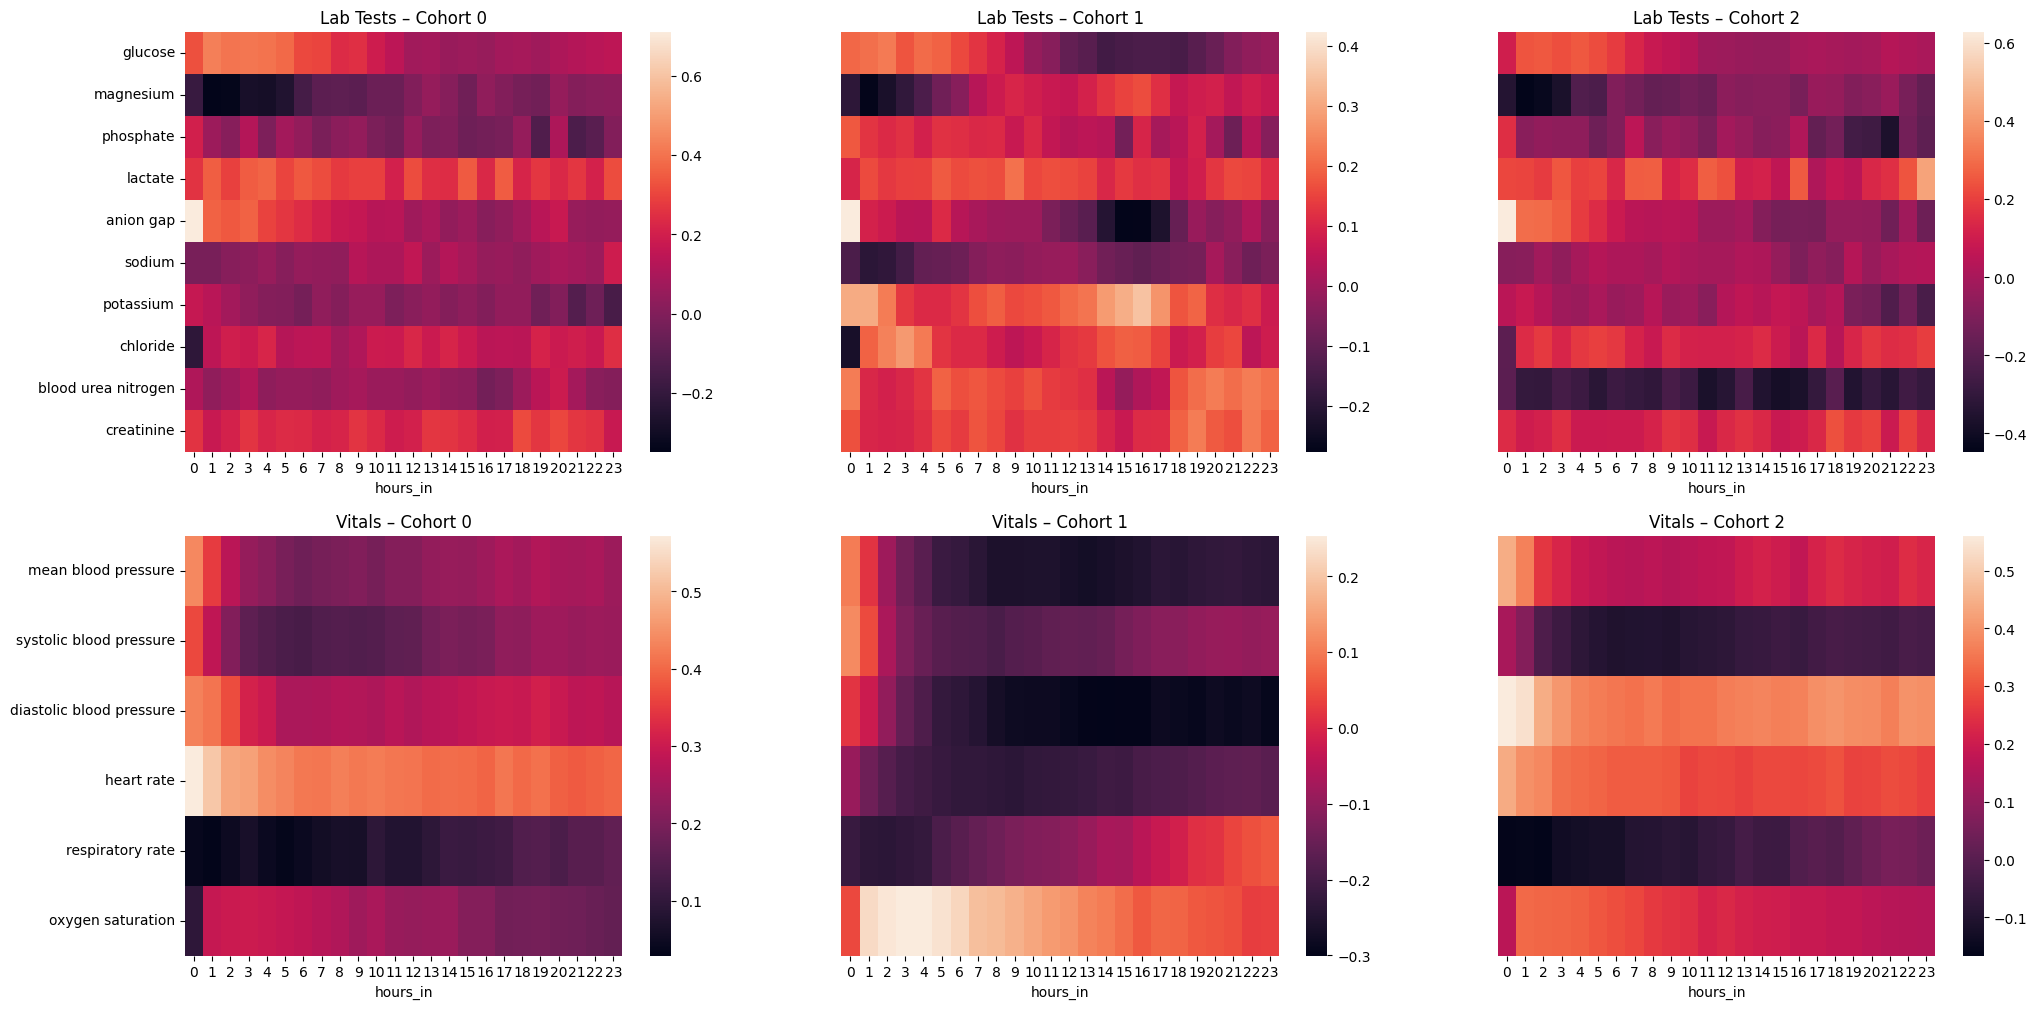

In [9]:
num_cohorts = len(np.unique(labs_df.index.get_level_values(0)))
fig, axs = plt.subplots(nrows=2, ncols=num_cohorts)
fig.set_size_inches(24, 12)
for i in np.arange(num_cohorts):
    plot_df = labs_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[0, i], yticklabels=True if i==0 else False).set(title=f'Lab Tests – Cohort {i}')
for i in np.arange(num_cohorts):
    plot_df = vitals_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[1, i], yticklabels=True if i==0 else False).set(title=f'Vitals – Cohort {i}')
plt.savefig('../img/heatmap_lab_abl_24')

**** Analysis required ****
From the heatmap plots there are some trends in the physiological data that seems to show a distinction between cohorts. In case of labs glucose and blood area nitrogen seems to be different between the three cohorts. However, some of the vitals definitely show different trends in some cases. Blood pressure across the different cohorts is different. When cohort 0 patients have a diastolic blood pressure that tends to drop the longer the patient stays, patients from cohort 2 have a diastolic blood pressure that tends to increase. 

#### 2.2.2. Heatmap plots for experiment 2 (48 hours)

Let's run the `get_heatmap_data()` function using the cohorts discovered in experiment 2 (48 hour cutoff period and 24 hour gap period):

In [10]:
%%time
labs_df, vitals_df = get_heatmap_data(cutoff_hours=48, gap_hours=24,
                                      cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_48.npy')

CPU times: user 6.9 s, sys: 21.7 s, total: 28.6 s
Wall time: 24.1 s


Let's plot the heatmaps for the selected lab tests and vitals:

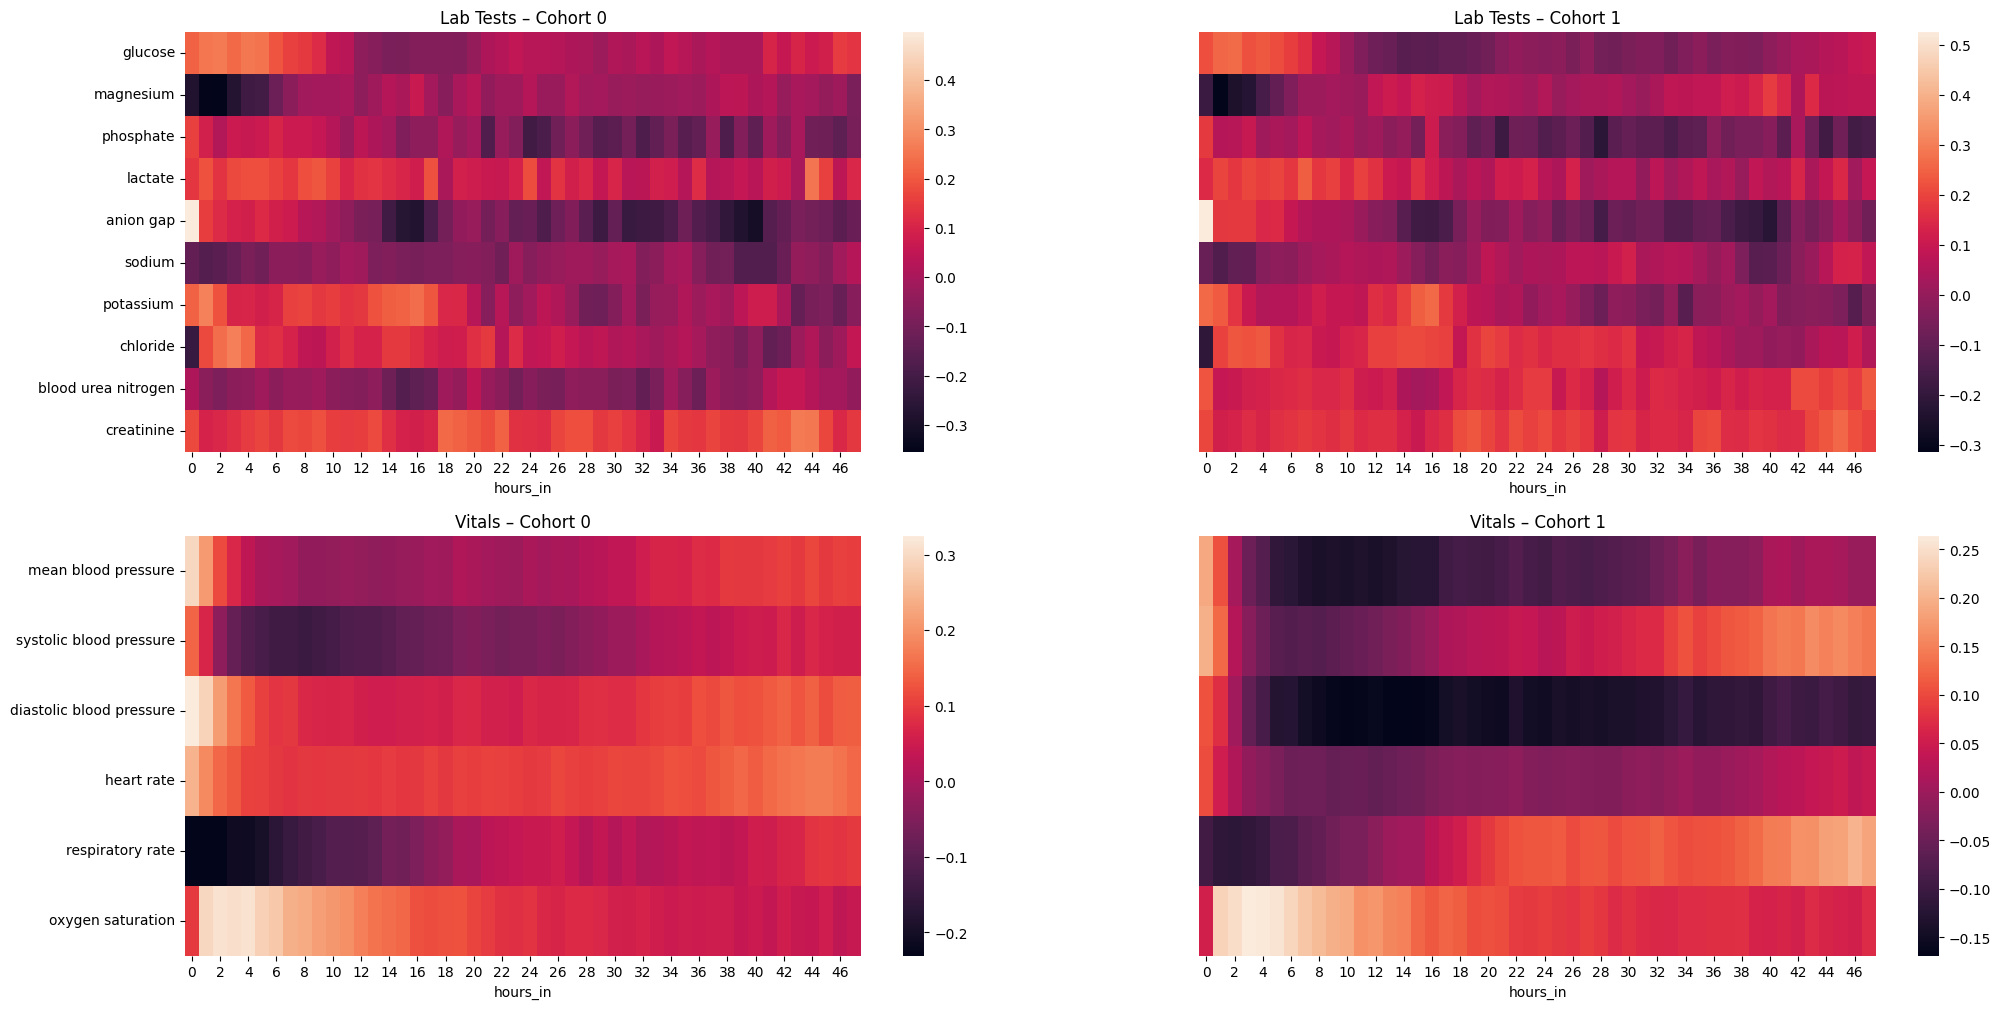

In [11]:
num_cohorts = len(np.unique(labs_df.index.get_level_values(0)))
fig, axs = plt.subplots(nrows=2, ncols=num_cohorts)
fig.set_size_inches(24, 12)
for i in np.arange(num_cohorts):
    plot_df = labs_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[0, i], yticklabels=True if i==0 else False).set(title=f'Lab Tests – Cohort {i}')
for i in np.arange(num_cohorts):
    plot_df = vitals_df.unstack(1).stack(1).query(f'cohort == {i}').droplevel(0)
    sns.heatmap(plot_df, ax=axs[1, i], yticklabels=True if i==0 else False).set(title=f'Vitals – Cohort {i}')
plt.savefig('../img/heatmap_lab_abl_48')

**** Analysis required ****In the 48 hour experiment, labs do not show significant differences between the two cohorts. However, the vitals show changes in the blood pressure where cohort 1 trend is more on the high side compared to cohort 0.

## 3. Predicting In-Hospital Mortality

As mentioned in the previous section, the paper uses a two-step pipeline to: 1) identify relevant patient cohorts, and 2) use those relevant cohorts as separate tasks in a multi-lask learning framework to predict in-hospital mortality. In this section, we will focus on the second step of the pipeline, i.e., use multi-task learning to make in-hospital mortality predictions for different patient cohorts.

For benchmarking purposes of the entire pipeline, the authors compared the results from running the pipeline using unsupervised cohort discovery (step one) against cohorts created using the first careunit the patient went into which can be considered an engineered feature. We will show those results in the next subsections.

The overall performance of this model is measured using both macro and micro metrics (section 4.3 in the paper) where:
* In *micro* metrics all predicted probabilities for all patients are treated as if they come from a single classifier: $\text{Metric}_\text{Micro} = \text{Metric}([\hat{y}_0, ..., \hat{y}_k], [y_0, ..., y_K])$.
* In *macro* metrics probabilities are evaluated on a *per cohort* basis, and then averaged: $\text{Metric}_\text{Macro} = \dfrac{1}{K} \displaystyle\sum_{k=0}^K \text{Metric}(\hat{y}_K, y_K)$.

Paper suggests that, although micro metrics are the ones typically chosen in the literature, evaluating performance on different subpopulations will benefit from macro metrics instead of micro metrics specially when there is class imbalance in every cohort. All results show macro and micro versions of the metrics for the aggregate performance of the models.

All results being used for comparison between models by the paper will use three metrics:
* AUC (Area Under the ROC Curve) for every cohort and, for the aggregate performance, macro and micro.
* PPV (Positive Predictive Value which is same as Precision) for every cohort and, for the aggregate performance, macro and micro. This PPV is calculated at a sensitivity of 80%, a value selected by the paper authors.
* Specificity for every cohort and, for the aggregate performance, macro and micro. This specificity is calculated at a sensitivity of 80%, a value selected by the paper authors.

All in-hospital mortality prediction tasks are implemented using the function `run_mortality_prediction_task()`. This function will call other functions to prepare the data, split the data in training/validation/test data sets, train the corresponding model, predict using the resulting model, and calculate the metrics of the model.

### 3.1. Predictions without Bootstrapping

In this section all in-hospital mortality predictions across the two models, global and multi-task learning, and across the two experiments, 24 hours and 48 hours, are calculated for the three metrics; AUC, PPV (precision) @80% sensitivity, and Specificity @80% sensitivity; using the test set (20% of the original dataset). No bootstrapping is done.

#### 3.1.1. In-Hospital Mortality Prediction – Baseline (*Global*) Model at 24 Hours

Let's first run the mortality prediction task using the *global* model (baseline) in the 24 hour experiment setting. In this experiment, the cutoff period is 24 hours and the gap period is 12 hours, meaning model can only feed from patient data collected during the first 24 hours of the ICU stay, and predict mortality 36 hours after patient goes into the ICU to avoid label leakage. In terms of the cohort type, let's go with careunits first:

In [4]:
%%time

from mtl_patients_ablation import run_mortality_prediction_task

metrics_global_24_careunits_df = run_mortality_prediction_task(model_type='global', cutoff_hours=24, gap_hours=12, cohort_criteria_to_select='careunits',save_to_folder='../data/ablation_data/',)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 206)
    Number of positive samples: 2321
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running the Mortality Prediction Task
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Calculating number of training samples in cohort...
        # of patients in cohort CCU is 3464
        # of patients in cohort CSRU is 4848
        # of patients in cohort MICU is 7912
        # of patients in cohort SICU is 3696
        # of patients in cohort TSICU is 2978
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Training 'global' model...
Model: "single_task_learning_model"
_________________________________________________

2023-04-14 15:25:12.718886: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 905661696 exceeds 10% of free system memory.
2023-04-14 15:25:13.859051: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 905661696 exceeds 10% of free system memory.
2023-04-14 15:25:14.702883: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 905661696 exceeds 10% of free system memory.


Epoch 1/30
229/229 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8888

2023-04-14 15:25:34.596729: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129414144 exceeds 10% of free system memory.
2023-04-14 15:25:34.780550: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129414144 exceeds 10% of free system memory.


229/229 [==============================] - 20s 73ms/step - loss: 0.4773 - accuracy: 0.8888 - val_loss: 0.3265 - val_accuracy: 0.9291
Epoch 2/30
229/229 [==============================] - 13s 55ms/step - loss: 0.2913 - accuracy: 0.9290 - val_loss: 0.2738 - val_accuracy: 0.9291
Epoch 3/30
229/229 [==============================] - 14s 59ms/step - loss: 0.2566 - accuracy: 0.9290 - val_loss: 0.2522 - val_accuracy: 0.9291
Epoch 4/30
229/229 [==============================] - 16s 71ms/step - loss: 0.2391 - accuracy: 0.9290 - val_loss: 0.2409 - val_accuracy: 0.9291
Epoch 5/30
229/229 [==============================] - 14s 61ms/step - loss: 0.2266 - accuracy: 0.9291 - val_loss: 0.2323 - val_accuracy: 0.9294
Epoch 6/30
229/229 [==============================] - 16s 72ms/step - loss: 0.2184 - accuracy: 0.9293 - val_loss: 0.2260 - val_accuracy: 0.9297
Epoch 7/30
229/229 [==============================] - 16s 72ms/step - loss: 0.2121 - accuracy: 0.9298 - val_loss: 0.2216 - val_accuracy: 0.9300
Epo

In [5]:
metrics_global_24_careunits_df.round(3)

,AUC,PPV,Specificity
CCU,0.841,0.179,0.756
CSRU,0.895,0.118,0.893
MICU,0.806,0.222,0.671
SICU,0.819,0.180,0.696
TSICU,0.830,0.117,0.582
Macro,0.838,0.163,0.720
Micro,0.843,0.178,0.718


Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [2]:
%%time
metrics_global_24_unsupervised_df = run_mortality_prediction_task(model_type='global', cutoff_hours=24, gap_hours=12,
                                                                  cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_24.npy',save_to_folder='../data/ablation_data/',)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 206)
    Number of positive samples: 2321
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running the Mortality Prediction Task
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Calculating number of training samples in cohort...
        # of patients in cohort 0 is 5108
        # of patients in cohort 1 is 14139
        # of patients in cohort 2 is 3651
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Training 'global' model...
Model: "single_task_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)   

In [3]:
metrics_global_24_unsupervised_df.round(3)

,AUC,PPV,Specificity
0,0.855,0.260,0.746
1,0.827,0.169,0.691
2,0.845,0.052,0.712
Macro,0.842,0.160,0.716
Micro,0.843,0.178,0.718


#### 3.1.2. In-Hospital Mortality Prediction – Baseline (*Global*) Model at 48 Hours

Let's now run the mortality prediction task using the *global* model (baseline) in the 48 hour experiment setting. In this experiment, the cutoff period is 48 hours and the gap period is 24 hours, meaning model can only feed from patient data collected during the first 48 hours of the ICU stay, and predict mortality 72 hours after patient goes into the ICU to avoid label leakage. In terms of the cohort type, let's go with careunits first:

In [2]:
%%time
metrics_global_48_careunits_df = run_mortality_prediction_task(model_type='global', cutoff_hours=48, gap_hours=24, cohort_criteria_to_select='careunits',save_to_folder='../data/ablation_data/',)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 206)
    Number of positive samples: 1739
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running the Mortality Prediction Task
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Calculating number of training samples in cohort...
        # of patients in cohort CCU is 3052
        # of patients in cohort CSRU is 4806
        # of patients in cohort MICU is 7309
        # of patients in cohort SICU is 3358
        # of patients in cohort TSICU is 2783
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Training 'global' model...
Model: "single_task_learning_model"
__________________________________________________

2023-04-14 16:11:38.449796: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.
2023-04-14 16:11:40.823297: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.
2023-04-14 16:11:42.717254: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.


Epoch 1/30
214/214 [==============================] - 34s 143ms/step - loss: 0.5711 - accuracy: 0.8713 - val_loss: 0.4824 - val_accuracy: 0.9429
Epoch 2/30
214/214 [==============================] - 29s 136ms/step - loss: 0.4398 - accuracy: 0.9429 - val_loss: 0.3927 - val_accuracy: 0.9429
Epoch 3/30
214/214 [==============================] - 29s 134ms/step - loss: 0.3552 - accuracy: 0.9429 - val_loss: 0.3236 - val_accuracy: 0.9429
Epoch 4/30
214/214 [==============================] - 25s 116ms/step - loss: 0.2962 - accuracy: 0.9428 - val_loss: 0.2722 - val_accuracy: 0.9429
Epoch 5/30
214/214 [==============================] - 25s 119ms/step - loss: 0.2483 - accuracy: 0.9428 - val_loss: 0.2355 - val_accuracy: 0.9429
Epoch 6/30
214/214 [==============================] - 24s 114ms/step - loss: 0.2187 - accuracy: 0.9429 - val_loss: 0.2146 - val_accuracy: 0.9429
Epoch 7/30
214/214 [==============================] - 27s 125ms/step - loss: 0.2034 - accuracy: 0.9429 - val_loss: 0.2039 - val_ac

2023-04-14 16:25:06.046379: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 481664256 exceeds 10% of free system memory.
2023-04-14 16:25:06.666882: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 481664256 exceeds 10% of free system memory.


191/191 [==============================] - 4s 17ms/step
    Done!
CPU times: user 17min 39s, sys: 2min 13s, total: 19min 53s
Wall time: 14min 52s


In [3]:
metrics_global_48_careunits_df.round(3)

,AUC,PPV,Specificity
CCU,0.806,0.168,0.739
CSRU,0.913,0.053,0.826
MICU,0.809,0.180,0.676
SICU,0.814,0.160,0.728
TSICU,0.805,0.118,0.678
Macro,0.829,0.136,0.729
Micro,0.834,0.154,0.735


Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [2]:
%%time
metrics_global_48_unsupervised_df = run_mortality_prediction_task(model_type='global', cutoff_hours=48, gap_hours=24,
                                                                  cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_48.npy',save_to_folder='../data/ablation_data/',)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 206)
    Number of positive samples: 1739
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running the Mortality Prediction Task
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Calculating number of training samples in cohort...
        # of patients in cohort 0 is 9125
        # of patients in cohort 1 is 12183
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Training 'global' model...
Model: "single_task_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                142

2023-04-14 16:28:31.746155: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.
2023-04-14 16:28:33.715226: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.
2023-04-14 16:28:35.283425: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.


Epoch 1/30
214/214 [==============================] - 31s 133ms/step - loss: 0.5711 - accuracy: 0.8713 - val_loss: 0.4824 - val_accuracy: 0.9429
Epoch 2/30
214/214 [==============================] - 26s 119ms/step - loss: 0.4398 - accuracy: 0.9429 - val_loss: 0.3927 - val_accuracy: 0.9429
Epoch 3/30
214/214 [==============================] - 25s 117ms/step - loss: 0.3552 - accuracy: 0.9429 - val_loss: 0.3236 - val_accuracy: 0.9429
Epoch 4/30
214/214 [==============================] - 27s 126ms/step - loss: 0.2962 - accuracy: 0.9428 - val_loss: 0.2722 - val_accuracy: 0.9429
Epoch 5/30
214/214 [==============================] - 26s 121ms/step - loss: 0.2483 - accuracy: 0.9428 - val_loss: 0.2355 - val_accuracy: 0.9429
Epoch 6/30
214/214 [==============================] - 26s 121ms/step - loss: 0.2187 - accuracy: 0.9429 - val_loss: 0.2146 - val_accuracy: 0.9429
Epoch 7/30
214/214 [==============================] - 28s 132ms/step - loss: 0.2034 - accuracy: 0.9429 - val_loss: 0.2039 - val_ac

2023-04-14 16:42:58.404069: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 481664256 exceeds 10% of free system memory.
2023-04-14 16:42:59.109052: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 481664256 exceeds 10% of free system memory.


191/191 [==============================] - 5s 21ms/step
    Done!
CPU times: user 18min 34s, sys: 2min 14s, total: 20min 48s
Wall time: 15min 44s


In [3]:
metrics_global_48_unsupervised_df.round(3)

,AUC,PPV,Specificity
0,0.845,0.129,0.772
1,0.816,0.180,0.731
Macro,0.831,0.155,0.751
Micro,0.834,0.154,0.735


#### 3.1.3. In-Hospital Mortality Prediction – Multi-Task Learning Model at 24 Hours

Let's now run the mortality prediction task using the multi-task learning model in the 24 hour experiment setting. In this experiment, the cutoff period is 24 hours and the gap period is 12 hours, meaning model can only feed from patient data collected during the first 24 hours of the ICU stay, and predict mortality 36 hours after patient goes into the ICU to avoid label leakage. In terms of the cohort type, let's go with careunits first:

In [9]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')
metrics_mtl_24_careunits_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=24, gap_hours=12, cohort_criteria_to_select='careunits',save_to_folder='../data/ablation_data/',)

Start Cell Execution at : 14/04/2023 12:56:33
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 206)
    Number of positive samples: 2321
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running the Mortality Prediction Task
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Calculating number of training samples in cohort...
        # of patients in cohort CCU is 3464
        # of patients in cohort CSRU is 4848
        # of patients in cohort MICU is 7912
        # of patients in cohort SICU is 3696
        # of patients in cohort TSICU is 2978
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Training 'multitask' model...
Model: "multitask_learning_model"
________________________________________________

In [10]:
metrics_mtl_24_careunits_df.round(3)

,AUC,PPV,Specificity
CCU,0.821,0.136,0.661
CSRU,0.893,0.103,0.876
MICU,0.809,0.217,0.660
SICU,0.779,0.152,0.629
TSICU,0.825,0.161,0.709
Macro,0.826,0.154,0.707
Micro,0.835,0.177,0.717


Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [2]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')
metrics_mtl_24_unsupervised_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=24, gap_hours=12,
                                                               cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_24.npy',save_to_folder='../data/ablation_data/',)

Start Cell Execution at : 14/04/2023 13:06:58
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 24]...
        New X_discrete.shape: (808539, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 24 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 1138 out of 11403
        SICU: 409 out of 5187
        CCU: 344 out of 4907
        CSRU: 139 out of 6971
        TSICU: 291 out of 4245
    Final shape of X: (32713, 24, 206)
    Number of positive samples: 2321
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running the Mortality Prediction Task
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Calculating number of training samples in cohort...
        # of patients in cohort 0 is 5108
        # of patients in cohort 1 is 14139
        # of patients in cohort 2 is 3651
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Training 'multitask' model...
Model: "multitask_learning_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape   

In [3]:
metrics_mtl_24_unsupervised_df.round(3)

,AUC,PPV,Specificity
0,0.849,0.246,0.727
1,0.821,0.169,0.692
2,0.839,0.041,0.629
Macro,0.837,0.152,0.683
Micro,0.837,0.174,0.711


#### 3.1.4. In-Hospital Mortality Prediction – Multi-Task Learning Model at 48 Hours

Let's now run the mortality prediction task using the multi-task learning model in the 48 hour experiment setting. In this experiment, the cutoff period is 48 hours and the gap period is 24 hours, meaning model can only feed from patient data collected during the first 48 hours of the ICU stay, and predict mortality 72 hours after patient goes into the ICU to avoid label leakage. In terms of the cohort type, let's go with careunits first:

In [2]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')
metrics_mtl_48_careunits_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=48, gap_hours=24, cohort_criteria_to_select='careunits',save_to_folder='../data/ablation_data/',)

Start Cell Execution at : 14/04/2023 13:20:27
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 206)
    Number of positive samples: 1739
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running the Mortality Prediction Task
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Calculating number of training samples in cohort...
        # of patients in cohort CCU is 3052
        # of patients in cohort CSRU is 4806
        # of patients in cohort MICU is 7309
        # of patients in cohort SICU is 3358
        # of patients in cohort TSICU is 2783
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Training 'multitask' model...
Model: "multitask_learning_model"
_________________________________________________

2023-04-14 17:21:41.049321: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.
2023-04-14 17:21:43.184259: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.
2023-04-14 17:21:44.791795: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.


Epoch 1/30
214/214 [==============================] - 36s 146ms/step - loss: 0.5461 - CCU_loss: 0.0938 - CSRU_loss: 0.1032 - MICU_loss: 0.1778 - SICU_loss: 0.0769 - TSICU_loss: 0.0944 - CCU_accuracy: 0.6510 - CSRU_accuracy: 0.9360 - MICU_accuracy: 0.9057 - SICU_accuracy: 0.9372 - TSICU_accuracy: 0.3293 - val_loss: 2.4035 - val_CCU_loss: 0.6165 - val_CSRU_loss: 0.3666 - val_MICU_loss: 0.3863 - val_SICU_loss: 0.3647 - val_TSICU_loss: 0.6695 - val_CCU_accuracy: 0.7346 - val_CSRU_accuracy: 0.9429 - val_MICU_accuracy: 0.9386 - val_SICU_accuracy: 0.9429 - val_TSICU_accuracy: 0.5589
Epoch 2/30
214/214 [==============================] - 31s 144ms/step - loss: 0.3848 - CCU_loss: 0.0786 - CSRU_loss: 0.0531 - MICU_loss: 0.1298 - SICU_loss: 0.0509 - TSICU_loss: 0.0724 - CCU_accuracy: 0.8754 - CSRU_accuracy: 0.9429 - MICU_accuracy: 0.9421 - SICU_accuracy: 0.9425 - TSICU_accuracy: 0.8053 - val_loss: 1.7417 - val_CCU_loss: 0.4575 - val_CSRU_loss: 0.2930 - val_MICU_loss: 0.2830 - val_SICU_loss: 0.2905

2023-04-14 17:37:27.078362: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 481664256 exceeds 10% of free system memory.
2023-04-14 17:37:27.668823: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 481664256 exceeds 10% of free system memory.


191/191 [==============================] - 4s 17ms/step
    Done!
CPU times: user 19min 45s, sys: 2min 16s, total: 22min 2s
Wall time: 17min 5s


In [3]:
metrics_mtl_48_careunits_df.round(3)

,AUC,PPV,Specificity
CCU,0.806,0.164,0.732
CSRU,0.885,0.043,0.783
MICU,0.808,0.163,0.633
SICU,0.835,0.160,0.727
TSICU,0.801,0.105,0.635
Macro,0.827,0.127,0.702
Micro,0.836,0.151,0.728


Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [2]:
%%time
cell_execution_time = datetime.now(pytz.timezone('America/New_York')).strftime("%d/%m/%Y %H:%M:%S")
print(f'Start Cell Execution at : {cell_execution_time}')
metrics_mtl_48_unsupervised_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=48, gap_hours=24,
                                                               cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_48.npy',save_to_folder='../data/ablation_data/',)

Start Cell Execution at : 14/04/2023 13:44:33
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Preparing the data
--------------------------------------------------------------------------------
    Loading data from MIMIC-Extract pipeline...
    Adding SAPS II score to static dataset...
    Adding mortality columns to static dataset...
    Discretizing X...
        X.shape: (2200954, 29), X.subject_id.nunique(): 34472


/notebooks/notebooks/../code/mtl_patients_ablation.py:608: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, feature_cols] = X_words


        X_discrete.shape: (2200954, 199), X_discrete.subject_id.nunique(): 34472
    Keep only X_discrete[X_discrete.hours_in < 48]...
        New X_discrete.shape: (1349653, 197), new X_discrete.subject_id.nunique(): 34472
    Padding patients with less than 48 hours of data...
    Merging dataframes to create X_full...


/notebooks/notebooks/../code/mtl_patients_ablation.py:633: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'ethnicity'] = static_to_keep_df['ethnicity'].apply(categorize_ethnicity)
/notebooks/notebooks/../code/mtl_patients_ablation.py:634: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  static_to_keep_df.loc[:, 'age'] = static_to_keep_df['age'].apply(categorize_age)


    Mortality per careunit...
        MICU: 866 out of 10409
        SICU: 303 out of 4815
        CCU: 258 out of 4403
        CSRU: 110 out of 6865
        TSICU: 202 out of 3950
    Final shape of X: (30442, 48, 206)
    Number of positive samples: 1739
    Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running the Mortality Prediction Task
--------------------------------------------------------------------------------
    Splitting data into train/validation/test sets...
    Calculating number of training samples in cohort...
        # of patients in cohort 0 is 9125
        # of patients in cohort 1 is 12183
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Training 'multitask' model...
Model: "multitask_learning_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to             

2023-04-14 17:45:53.184979: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.
2023-04-14 17:45:55.291393: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.
2023-04-14 17:45:56.988298: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1685548032 exceeds 10% of free system memory.


Epoch 1/30
214/214 [==============================] - 30s 116ms/step - loss: 0.5477 - 0_loss: 0.2686 - 1_loss: 0.2791 - 0_accuracy: 0.8522 - 1_accuracy: 0.9353 - val_loss: 0.9925 - val_0_loss: 0.5522 - val_1_loss: 0.4403 - val_0_accuracy: 0.9419 - val_1_accuracy: 0.9429
Epoch 2/30
214/214 [==============================] - 25s 119ms/step - loss: 0.4233 - 0_loss: 0.2114 - 1_loss: 0.2119 - 0_accuracy: 0.9428 - 1_accuracy: 0.9427 - val_loss: 0.8009 - val_0_loss: 0.4538 - val_1_loss: 0.3471 - val_0_accuracy: 0.9429 - val_1_accuracy: 0.9429
Epoch 3/30
214/214 [==============================] - 27s 125ms/step - loss: 0.3293 - 0_loss: 0.1494 - 1_loss: 0.1799 - 0_accuracy: 0.9429 - 1_accuracy: 0.9428 - val_loss: 0.6877 - val_0_loss: 0.3411 - val_1_loss: 0.3466 - val_0_accuracy: 0.9429 - val_1_accuracy: 0.9429
Epoch 4/30
214/214 [==============================] - 27s 128ms/step - loss: 0.2544 - 0_loss: 0.0963 - 1_loss: 0.1581 - 0_accuracy: 0.9400 - 1_accuracy: 0.9429 - val_loss: 0.6400 - val_0_

2023-04-14 17:57:45.776020: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 481664256 exceeds 10% of free system memory.
2023-04-14 17:57:46.356456: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 481664256 exceeds 10% of free system memory.


191/191 [==============================] - 3s 14ms/step
    Done!
CPU times: user 15min 41s, sys: 1min 59s, total: 17min 41s
Wall time: 13min 19s


In [3]:
metrics_mtl_48_unsupervised_df.round(3)

,AUC,PPV,Specificity
0,0.843,0.106,0.715
1,0.798,0.135,0.617
Macro,0.820,0.120,0.666
Micro,0.821,0.131,0.680


#### 3.1.5. Summary

Similar to Table 4 in paper, the dataframe below summarizes all results.

In [9]:
# Load global and multitask dfs for 24 and 48 hour experiment
metrics_global_24_careunits_df = pd.read_hdf('../data/ablation_data/results/model_global_24+12_careunits_bootstrap-OFF.h5')
metrics_global_24_unsupervised_df = pd.read_hdf('../data/ablation_data/results/model_global_24+12_unsupervised_bootstrap-OFF.h5')
metrics_mtl_24_careunits_df = pd.read_hdf('../data/ablation_data/results/model_multitask_24+12_careunits_bootstrap-OFF.h5')
metrics_mtl_24_unsupervised_df = pd.read_hdf('../data/ablation_data/results/model_multitask_24+12_unsupervised_bootstrap-OFF.h5')
metrics_global_48_careunits_df = pd.read_hdf('../data/ablation_data/results/model_global_48+24_careunits_bootstrap-OFF.h5')
metrics_global_48_unsupervised_df = pd.read_hdf('../data/ablation_data/results/model_global_48+24_unsupervised_bootstrap-OFF.h5')
metrics_mtl_48_careunits_df = pd.read_hdf('../data/ablation_data/results/model_multitask_48+24_careunits_bootstrap-OFF.h5')
metrics_mtl_48_unsupervised_df = pd.read_hdf('../data/ablation_data/results/model_multitask_48+24_unsupervised_bootstrap-OFF.h5')

In [10]:
summary_a_df = metrics_global_24_unsupervised_df.reset_index()
summary_a_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_a_df['Cohort type'] = 'Unsupervised'
summary_a_df['Model'] = 'Global'
summary_a_df['Experiment'] = '24 hours'

summary_b_df = metrics_global_24_careunits_df.reset_index()
summary_b_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_b_df['Cohort type'] = 'Careunits'
summary_b_df['Model'] = 'Global'
summary_b_df['Experiment'] = '24 hours'

summary_c_df = metrics_mtl_24_unsupervised_df.reset_index()
summary_c_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_c_df['Cohort type'] = 'Unsupervised'
summary_c_df['Model'] = 'Multi-task'
summary_c_df['Experiment'] = '24 hours'

summary_d_df = metrics_mtl_24_careunits_df.reset_index()
summary_d_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_d_df['Cohort type'] = 'Careunits'
summary_d_df['Model'] = 'Multi-task'
summary_d_df['Experiment'] = '24 hours'

summary_24_df = pd.concat([summary_a_df, summary_b_df, summary_c_df, summary_d_df])

summary_e_df = metrics_global_48_unsupervised_df.reset_index()
summary_e_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_e_df['Cohort type'] = 'Unsupervised'
summary_e_df['Model'] = 'Global'
summary_e_df['Experiment'] = '48 hours'

summary_f_df = metrics_global_48_careunits_df.reset_index()
summary_f_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_f_df['Cohort type'] = 'Careunits'
summary_f_df['Model'] = 'Global'
summary_f_df['Experiment'] = '48 hours'

summary_g_df = metrics_mtl_48_unsupervised_df.reset_index()
summary_g_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_g_df['Cohort type'] = 'Unsupervised'
summary_g_df['Model'] = 'Multi-task'
summary_g_df['Experiment'] = '48 hours'

summary_h_df = metrics_mtl_48_careunits_df.reset_index()
summary_h_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_h_df['Cohort type'] = 'Careunits'
summary_h_df['Model'] = 'Multi-task'
summary_h_df['Experiment'] = '48 hours'

summary_48_df = pd.concat([summary_e_df, summary_f_df, summary_g_df, summary_h_df])

summary_df = pd.concat([summary_24_df, summary_48_df])

# This is a trick using a categorical data type to have Macro and Micro after Cohort names while displaying
from pandas.api.types import CategoricalDtype
cohort = CategoricalDtype(['0', '1', '2', 'CCU', 'CSRU', 'MICU', 'SICU', 'TSICU', 'Macro', 'Micro'], ordered=True)
summary_df['Cohort'] = summary_df['Cohort'].astype(cohort)

summary_df = pd.melt(summary_df, id_vars=['Cohort', 'Cohort type', 'Model', 'Experiment'], var_name='Metric')
summary_df = summary_df.set_index(['Experiment', 'Cohort type', 'Cohort'])
summary_df = summary_df.pivot(columns=['Metric', 'Model'], values='value')
summary_df = summary_df.round(3)
summary_df

Metric                            AUC               PPV             \
Model                          Global Multi-task Global Multi-task   
Experiment Cohort type  Cohort                                       
24 hours   Careunits    CCU     0.841      0.821  0.179      0.136   
                        CSRU    0.895      0.893  0.118      0.103   
                        MICU    0.806      0.809  0.222      0.217   
                        SICU    0.819      0.779  0.180      0.152   
                        TSICU   0.830      0.825  0.117      0.161   
                        Macro   0.838      0.826  0.163      0.154   
                        Micro   0.843      0.835  0.178      0.177   
           Unsupervised 0       0.855      0.849  0.260      0.246   
                        1       0.827      0.821  0.169      0.169   
                        2       0.845      0.839  0.052      0.041   
                        Macro   0.842      0.837  0.160      0.152   
                        Micro   0.843      0.837  0.178      0.174   
48 hours   Careunits    CCU     0.806      0.806  0.168      0.164   
                        CSRU    0.913      0.885  0.053      0.043   
                        MICU    0.809      0.808  0.180      0.163   
                        SICU    0.814      0.835  0.160      0.160   
                        TSICU   0.805      0.801  0.118      0.105   
                        Macro   0.829      0.827  0.136      0.127   
                        Micro   0.834      0.836  0.154      0.151   
           Unsupervised 0       0.845      0.843  0.129      0.106   
                        1       0.816      0.798  0.180      0.135   
                        Macro   0.831      0.820  0.155      0.120   
                        Micro   0.834      0.821  0.154      0.131   

Metric                         Specificity             
Model                               Global Multi-task  
Experiment Cohort type  Cohort                         
24 hours   Careunits    CCU          0.756      0.661  
                        CSRU         0.893      0.876  
                        MICU         0.671      0.660  
                        SICU         0.696      0.629  
                        TSICU        0.582      0.709  
                        Macro        0.720      0.707  
                        Micro        0.718      0.717  
           Unsupervised 0            0.746      0.727  
                        1            0.691      0.692  
                        2            0.712      0.629  
                        Macro        0.716      0.683  
                        Micro        0.718      0.711  
48 hours   Careunits    CCU          0.739      0.732  
                        CSRU         0.826      0.783  
                        MICU         0.676      0.633  
                        SICU         0.728      0.727  
                        TSICU        0.678      0.635  
                        Macro        0.729      0.702  
                        Micro        0.735      0.728  
           Unsupervised 0            0.772      0.715  
                        1            0.731      0.617  
                        Macro        0.751      0.666  
                        Micro        0.735      0.680

### 3.2. Predictions with Bootstrapping

In this section all in-hospital mortality predictions across the two models, global and multi-task learning, and across the two experiments, 24 hours and 48 hours, are calculated for the three metrics; AUC, PPV (precision) @80% sensitivity, and Specificity @80% sensitivity; using 100 bootstrapped samples of the test set (20% of the original dataset). The results will be metrics (AUC, PPV, and Specificity) for each bootstrapped sample. This will allow the comparison between the global model and the multi-task learning model using the Wilcoxon signed-rank test as indicated in the paper.

#### 3.2.1. In-Hospital Mortality Prediction – Baseline (*Global*) Model at 24 Hours

Let's first run the mortality prediction task using the *global* model (baseline) in the 24 hour experiment setting. In this experiment, the cutoff period is 24 hours and the gap period is 12 hours, meaning model can only feed from patient data collected during the first 24 hours of the ICU stay, and predict mortality 36 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [ ]:
%%time

from mtl_patients_ablation import run_mortality_prediction_task

metrics_global_24_careunits_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=24, gap_hours=12, cohort_criteria_to_select='careunits', bootstrap=True,save_to_folder='../data/ablation_data/',)

In [ ]:
pd.options.display.max_rows = 20
metrics_global_24_careunits_btstrp_df.round(3)

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [ ]:
%%time
metrics_global_24_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=24, gap_hours=12, bootstrap=True,
                                                                         cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_24.npy',save_to_folder='../data/ablation_data/',)

In [ ]:
metrics_global_24_unsupervised_btstrp_df.round(3)

#### 3.2.2. In-Hospital Mortality Prediction – Baseline (*Global*) Model at 48 Hours

Let's first run the mortality prediction task using the *global* model (baseline) in the 48 hour experiment setting. In this experiment, the cutoff period is 48 hours and the gap period is 24 hours, meaning model can only feed from patient data collected during the first 48 hours of the ICU stay, and predict mortality 72 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [ ]:
%%time

from mtl_patients_ablation import run_mortality_prediction_task

metrics_global_48_careunits_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=48, gap_hours=24, cohort_criteria_to_select='careunits', bootstrap=True,save_to_folder='../data/ablation_data/',)

In [ ]:
metrics_global_48_careunits_btstrp_df.round(3)

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [ ]:
%%time
metrics_global_48_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='global', cutoff_hours=48, gap_hours=24, bootstrap=True,
                                                                         cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_48.npy',save_to_folder='../data/ablation_data/',)

In [ ]:
metrics_global_48_unsupervised_btstrp_df.round(3)

#### 3.2.3. In-Hospital Mortality Prediction – Multi-Task Learning Model at 24 Hours

Let's now run the mortality prediction task using the multi-task learning model in the 24 hour experiment setting. In this experiment, the cutoff period is 24 hours and the gap period is 12 hours, meaning model can only feed from patient data collected during the first 24 hours of the ICU stay, and predict mortality 36 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [ ]:
%%time

from mtl_patients_ablation import run_mortality_prediction_task

metrics_mtl_24_careunits_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=24, gap_hours=12, cohort_criteria_to_select='careunits', bootstrap=True,save_to_folder='../data/ablation_data/',)

In [ ]:
metrics_mtl_24_careunits_btstrp_df.round(3)

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [ ]:
%%time
metrics_mtl_24_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=24, gap_hours=12, bootstrap=True,
                                                                      cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_24.npy',save_to_folder='../data/ablation_data/',)

In [ ]:
metrics_mtl_24_unsupervised_btstrp_df.round(3)

#### 3.2.4. In-Hospital Mortality Prediction – Multi-Task Learning Model at 48 Hours

Let's now run the mortality prediction task using the multi-task learning model in the 48 hour experiment setting. In this experiment, the cutoff period is 48 hours and the gap period is 24 hours, meaning model can only feed from patient data collected during the first 48 hours of the ICU stay, and predict mortality 72 hours after patient goes into the ICU to avoid label leakage. Since we are enabling bootstrapping, we will repeat same experiment with 100 bootstrapped samples from the test dataset. In terms of the cohort type, let's go with careunits first:

In [ ]:
%%time

from mtl_patients_ablation import run_mortality_prediction_task

metrics_mtl_48_careunits_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=48, gap_hours=24, cohort_criteria_to_select='careunits', bootstrap=True,save_to_folder='../data/ablation_data/',)

In [ ]:
metrics_mtl_48_careunits_btstrp_df.round(3)

Now, let's repeat the prediction task but this time using the groups fetched in an unsupervised way from step 1 proposed by the authors in the paper:

In [ ]:
%%time
metrics_mtl_48_unsupervised_btstrp_df = run_mortality_prediction_task(model_type='multitask', cutoff_hours=48, gap_hours=24, bootstrap=True,
                                                                      cohort_criteria_to_select='unsupervised', cohort_unsupervised_filename='../data/unsupervised_clusters_lab_abl_48.npy',save_to_folder='../data/ablation_data/',)

In [ ]:
metrics_mtl_48_unsupervised_btstrp_df.round(3)

#### 3.2.5. Summary

Similar to Table 4 in paper, the dataframe below summarizes all results. Due to bootstrapping we will get 100 metric (AUC, PPV, or Specificity) values for every combination of experiment (24 hours or 48 hours), cohort type (careunits or unsupervised), and model type (global or multi-task. We will reduce that table in a next step.

In [ ]:
summary_a_btstrp_df = metrics_global_24_unsupervised_btstrp_df.reset_index()
summary_a_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_a_btstrp_df['Cohort type'] = 'Unsupervised'
summary_a_btstrp_df['Model'] = 'Global'
summary_a_btstrp_df['Experiment'] = '24 hours'

summary_b_btstrp_df = metrics_global_24_careunits_btstrp_df.reset_index()
summary_b_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_b_btstrp_df['Cohort type'] = 'Careunits'
summary_b_btstrp_df['Model'] = 'Global'
summary_b_btstrp_df['Experiment'] = '24 hours'

summary_c_btstrp_df = metrics_mtl_24_unsupervised_btstrp_df.reset_index()
summary_c_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_c_btstrp_df['Cohort type'] = 'Unsupervised'
summary_c_btstrp_df['Model'] = 'Multi-task'
summary_c_btstrp_df['Experiment'] = '24 hours'

summary_d_btstrp_df = metrics_mtl_24_careunits_btstrp_df.reset_index()
summary_d_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_d_btstrp_df['Cohort type'] = 'Careunits'
summary_d_btstrp_df['Model'] = 'Multi-task'
summary_d_btstrp_df['Experiment'] = '24 hours'

summary_24_btstrp_df = pd.concat([summary_a_btstrp_df, summary_b_btstrp_df, summary_c_btstrp_df, summary_d_btstrp_df])

summary_e_btstrp_df = metrics_global_48_unsupervised_btstrp_df.reset_index()
summary_e_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_e_btstrp_df['Cohort type'] = 'Unsupervised'
summary_e_btstrp_df['Model'] = 'Global'
summary_e_btstrp_df['Experiment'] = '48 hours'

summary_f_btstrp_df = metrics_global_48_careunits_btstrp_df.reset_index()
summary_f_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_f_btstrp_df['Cohort type'] = 'Careunits'
summary_f_btstrp_df['Model'] = 'Global'
summary_f_btstrp_df['Experiment'] = '48 hours'

summary_g_btstrp_df = metrics_mtl_48_unsupervised_btstrp_df.reset_index()
summary_g_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_g_btstrp_df['Cohort type'] = 'Unsupervised'
summary_g_btstrp_df['Model'] = 'Multi-task'
summary_g_btstrp_df['Experiment'] = '48 hours'

summary_h_btstrp_df = metrics_mtl_48_careunits_btstrp_df.reset_index()
summary_h_btstrp_df.rename(columns={'index': 'Cohort'}, inplace=True)
summary_h_btstrp_df['Cohort type'] = 'Careunits'
summary_h_btstrp_df['Model'] = 'Multi-task'
summary_h_btstrp_df['Experiment'] = '48 hours'

summary_48_btstrp_df = pd.concat([summary_e_btstrp_df, summary_f_btstrp_df, summary_g_btstrp_df, summary_h_btstrp_df])

summary_btstrp_df = pd.concat([summary_24_btstrp_df, summary_48_btstrp_df])

# This is a trick using a categorical data type to have Macro and Micro after Cohort names while displaying
from pandas.api.types import CategoricalDtype
cohort = CategoricalDtype(['0', '1', '2', 'CCU', 'CSRU', 'MICU', 'SICU', 'TSICU', 'Macro', 'Micro'], ordered=True)
summary_btstrp_df['Cohort'] = summary_btstrp_df['Cohort'].astype(cohort)
summary_btstrp_df = summary_btstrp_df.dropna()

summary_btstrp_df = pd.melt(summary_btstrp_df, id_vars=['Cohort', 'Sample', 'Cohort type', 'Model', 'Experiment'], var_name='Metric')
summary_btstrp_df = summary_btstrp_df.set_index(['Experiment', 'Cohort type', 'Cohort', 'Sample'])
summary_btstrp_df = summary_btstrp_df.pivot(columns=['Metric', 'Model'], values='value')
summary_btstrp_df = summary_btstrp_df.round(3)
# Now summary_btstrp_df has all bootstrapped samples with right multi-indices for rows and columns!

##### 3.2.5.1. Mean values of metrics from bootstrapped samples

Let's get the mean values of the 100 bootstrapped samples:

In [ ]:
pd.options.display.max_rows = 999
summary_df = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).mean().round(3).dropna()
summary_df

##### 3.2.5.2 Wilcoxon Signed-Rank Test

Now it is time to apply the Wilcoxon Signed-Rank Test. [This video](https://www.youtube.com/watch?v=v4ZHlTbTOK8) has a very good detailed explanation of the Wilcoxon Signed-Rank Test which is a non-parametric version of the paired t-test used when there are not many samples (which is our case).

In [ ]:
from scipy.stats import wilcoxon

def calc_wilcoxon(grp_df, what):
    if (what == 'auc'):
        # calculate p-value for AUC using Wilcoxon Signed Rank Test
        x = grp_df[('AUC', 'Global')]
        y = grp_df[('AUC', 'Multi-task')]
        _, pvalue = wilcoxon(x, y)

    if (what == 'ppv'):
        # calculate p-value for PPV using Wilcoxon Signed Rank Test
        x = grp_df[('PPV', 'Global')]
        y = grp_df[('PPV', 'Multi-task')]
        _, pvalue = wilcoxon(x, y)
    
    if (what == 'specificity'):
        # calculate p-value for AUC using Wilcoxon Signed=Rank Test
        x = grp_df[('Specificity', 'Global')]
        y = grp_df[('Specificity', 'Multi-task')]
        _, pvalue = wilcoxon(x, y)

    return pvalue

In [ ]:
summary_df.loc[:, ('AUC', 'p-value')] = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).apply(calc_wilcoxon, what='auc')
summary_df.loc[:, ('PPV', 'p-value')] = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).apply(calc_wilcoxon, what='ppv')
summary_df.loc[:, ('Specificity', 'p-value')] = summary_btstrp_df.groupby(['Experiment', 'Cohort type', 'Cohort']).apply(calc_wilcoxon, what='specificity')
cols = [('AUC', 'Global'), ('AUC', 'Multi-task'), ('AUC', 'p-value'),
        ('PPV', 'Global'), ('PPV', 'Multi-task'), ('PPV', 'p-value'),
        ('Specificity', 'Global'), ('Specificity', 'Multi-task'), ('Specificity', 'p-value')]
summary_df = summary_df[cols]
summary_df

End time

In [ ]:
# store/print end time to measure runtime
endtime = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f'End time: {endtime}')

# store/print run time
print(f'This run took {endtime - starttime} hours:min:sec to run')